### Fetch data directory path

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']
result_dir_path = os.environ['RESULT_DIR_PATH']

### Import required modules

In [ ]:
import h5py
import numpy as np
from matplotlib import pyplot as plt, gridspec

### Utility functions

In [58]:
def show_kspace_slice(kspace_path, slice_idx=0, coil_idxs=[0, 5, 10], cmap='gray'):
    # convert kspace slice to real image
    hf = h5py.File(kspace_path)
    kspace_slice = hf['kspace'][slice_idx]
    kspace_slice = np.log(np.abs(kspace_slice) + 1e-9)
    
    kspace_title = kspace_path.split('/')[-1]
    
    plt.figure()
    plt.suptitle(f'{kspace_title} - slice {slice_idx}')
    for i, coil_idx in enumerate(coil_idxs):
        ax = plt.subplot(1, len(coil_idxs), i + 1)
        plt.title(f'coil {coil_idx}')
        ax.imshow(kspace_slice[coil_idx], cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [48]:
def show_image_slice(img_path, slice_idx=0, cmap='gray'):
    img_keys = ['image_grappa', 'image_input', 'image_label']
    img_title = img_path.split('/')[-1]
    
    hf = h5py.File(img_path)
    plt.figure()
    plt.suptitle(f'{img_title} - slice {slice_idx}')
    for j, key in enumerate(img_keys):
        ax = plt.subplot(1, len(img_keys), j + 1)
        img_slice = hf[key][slice_idx]
        plt.title(key)
        ax.imshow(img_slice, cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [49]:
def get_masked_kspace_with_1d_mask(kspace, mask):
    """ 아직 미완성~~ """
    mask = np.tile(mask, (mask.shape[0], 1))
    raise NotImplementedError

In [50]:
def show_image_slices(img_path, model_name: str = "", is_recon = True, slice_idxs=[0], cmap='gray'):
    img_title = img_path.split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(slice_idxs))
    
    fig_img.suptitle(f'[{model_name}] {img_title}')
    for i, slice_idx in enumerate(slice_idxs):
        with h5py.File(img_path, 'r') as hf:
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, i])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'slice {slice_idx}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [51]:
def compare_image_slice(img_paths=None, model_names=None, slice_idx=0, cmap='gray'):
    if img_paths is None:
        img_paths = []
    if len(img_paths) < 1:
        return
    
    img_title = img_paths[0].split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(img_paths))
    
    fig_img.suptitle(f'{img_title}')
    for idx, path in enumerate(img_paths):
        with h5py.File(path, 'r') as hf:
            is_recon = path.split('/')[-2] != 'image'
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, idx])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'{model_names[idx]}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [107]:
def is_equispaced_mask(mask, acc):
    prev_one_idx = -1
    cnt_not_equispaced = 0
    for idx, val in enumerate(mask):
        if val > 0:
            if (idx - prev_one_idx != acc
            and idx - prev_one_idx != 1
            and prev_one_idx >= 0):
                cnt_not_equispaced += 1
            prev_one_idx = idx
    return cnt_not_equispaced <= 2

### Data structure

**Image data (train/val)**

In [115]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


(16, 384, 384)


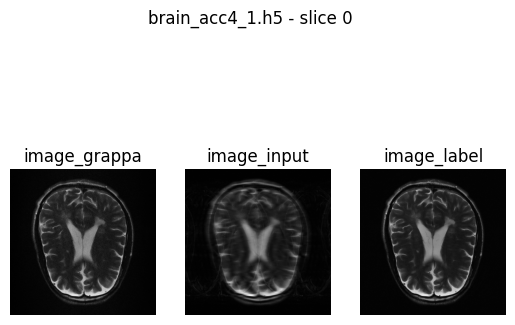

In [116]:
print(img['image_input'].shape)
show_image_slice(img_path)

**Kspace data (train/val)**

In [100]:
kspace_path = f'{data_dir_path}/train/kspace/brain_acc4_1.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


In [112]:
cnt_total_mask = 120
cnt_equispaced_mask = 0
acc = 8
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/train/kspace/brain_acc{acc}_{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=acc)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

# of equispaced masks: 120 / 120


(396,)
(16, 16, 768, 396)


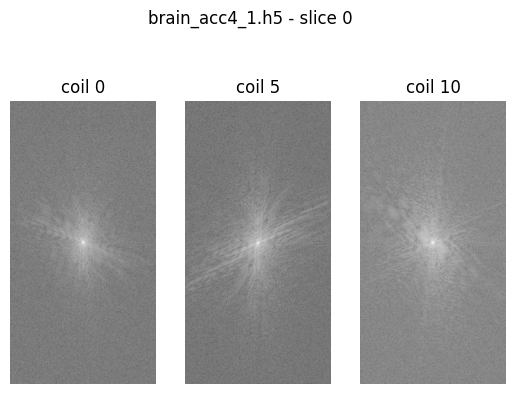

In [75]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)
show_kspace_slice(kspace_path)

**Image data (leaderboard)**

In [76]:
img_path = f'{data_dir_path}/leaderboard/acc5/image/brain_test1.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


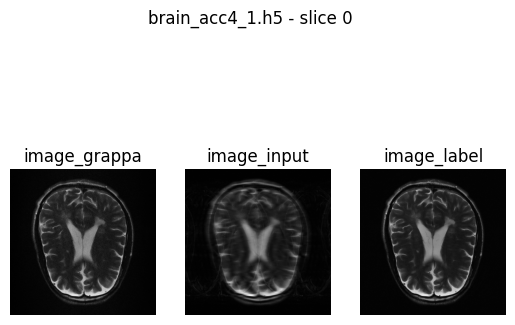

In [57]:
show_image_slice(img_path)

**Kspace data (leaderboard)**

In [77]:
kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test1.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


In [98]:
cnt_total_mask = 58
cnt_equispaced_mask = 0
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=5)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

# of equispaced masks: 58 / 58


In [62]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)

(396,)
(16, 14, 768, 396)


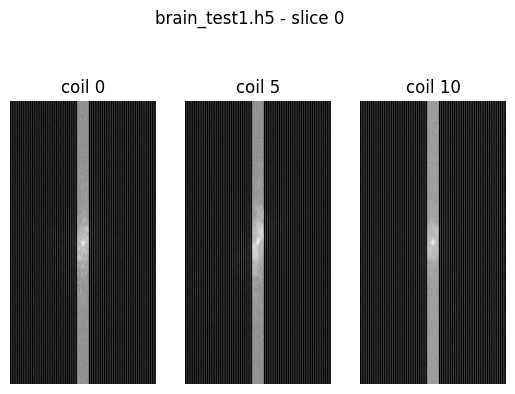

In [63]:
show_kspace_slice(kspace_path)

**정리**
- Image: slices x 384 x 384
- Kspace: slices x coils x 768 x 392/396
- train/val/leaderboard 모두 equispaced mask로 undersampled됨 (일부 mask에 **offset** 존재)
    - `fastmri.data.subsample.EquispacedMaskFunc()`으로 만들 수 있음

## Data preview

<Figure size 1500x1600 with 0 Axes>

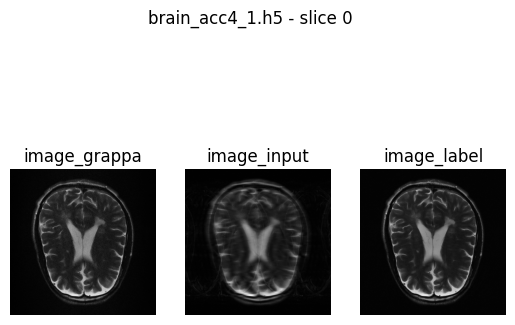

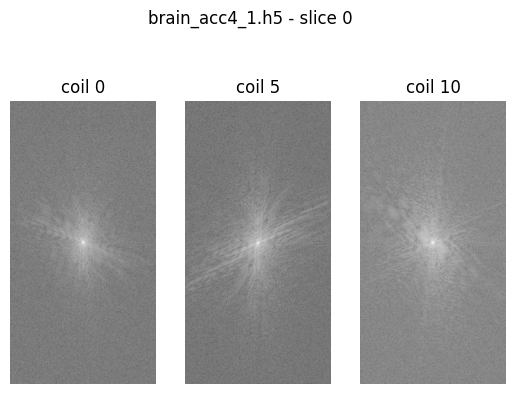

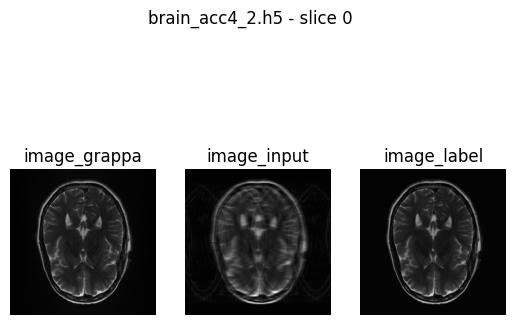

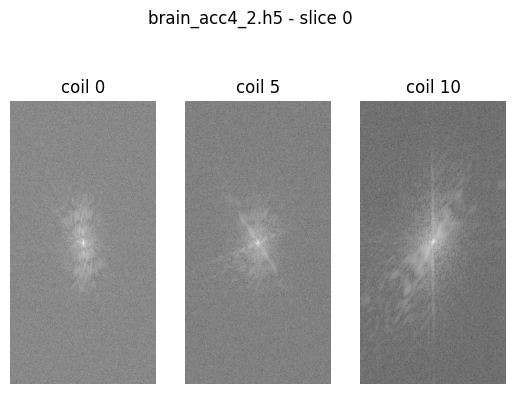

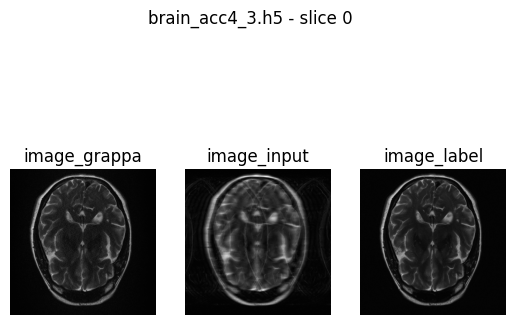

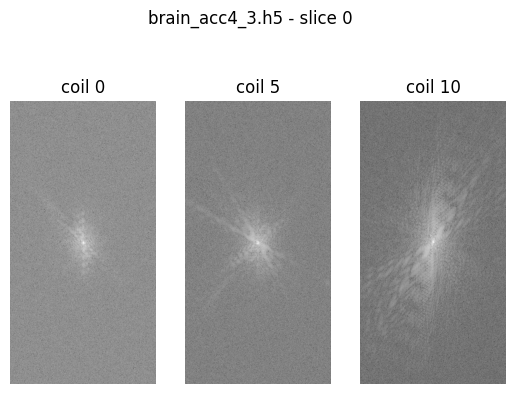

In [117]:
plt.figure(figsize=(15, 16))
for i in range(1, 4):
    img_path = f'{data_dir_path}/train/image/brain_acc4_{i}.h5'
    show_image_slice(img_path)
    
    kspace_path = f'{data_dir_path}/train/kspace/brain_acc4_{i}.h5'
    show_kspace_slice(kspace_path)

In [0]:
for i in range(1, 4):
    img_path = f'{data_dir_path}/leaderboard/acc5/image/brain_test{i}.h5'
    show_image_slices(img_path, model_name="ground_truth", slice_idxs=list(range(3)), is_recon=False)

In [0]:
for i in range(1, 4):
    img_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard(baseline_15epoch)/public/brain_test{i}.h5'
    show_image_slices(img_path, model_name='baseline_15epoch', slice_idxs=list(range(3)))
    
    img_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard(baseline_24epoch)/public/brain_test{i}.h5'
    show_image_slices(img_path, model_name='baseline_24epoch', slice_idxs=list(range(3)))

In [ ]:
img_paths = [f'{result_dir_path}/test_Varnet/reconstructions_leaderboard(baseline_15epoch)/public/brain_test1.h5',
             f'{result_dir_path}/test_Varnet/reconstructions_leaderboard(baseline_38epoch)/public/brain_test1.h5',
             f'{data_dir_path}/leaderboard/acc5/image/brain_test1.h5']
model_names = ['baseline_15epoch', 'baseline_38epoch', 'ground_truth']
compare_image_slice(img_paths, model_names)